# Heart Failure Prediction Using Applied Modeling
### Lambda school Unit2 Project

In [ ]:
import sys
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox

#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, mean_absolute_error
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV # Hyperparameter tuning

In [2]:
# Importing the file that is stored locally in my Google drive

from google.colab import drive
drive.mount('/content/gdrive/')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/"

%cd /content/gdrive/My Drive/Colab Notebooks/Unit 2/kaggle/ds32-water-pump-challenge/

DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/Unit 2/kaggle/ds32-water-pump-challenge/'

Mounted at /content/gdrive/
/content/gdrive/My Drive/Colab Notebooks/Unit 2/kaggle/ds32-water-pump-challenge


In [3]:
%ls

heart_failure_clinical_records_dataset.csv  test_features.csv
marketing_campaign.csv                      train_features.csv
new_submission.csv                          train_labels.csv
sample_submission.csv


### Data Wrangling

In [4]:
def wrangle(filepath):

  # Reading the file 
  df = pd.read_csv(filepath)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Renaming Column names for easy access
  df = df.rename(columns={'DEATH_EVENT': "Heart_failure"})
  df = df.drop(columns = 'time')

  return df

df = wrangle(DATAPATH+ 'heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Heart_failure
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1


### Checking for Null values

In [5]:
# Checking for null values
df.isnull().sum().sum()

0

In [6]:
# Binary classification problem
df['Heart_failure'].value_counts(normalize=True) * 100

0    67.892977
1    32.107023
Name: Heart_failure, dtype: float64

### Profile Report

In [7]:
# Profile Report
Report=ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Split Data

In [8]:
# Split data into feature matrix 'X' and target vector 'y'

target = 'Heart_failure'
X = df.drop(columns = [target,'sex'])                                    
y = df[target]

print(y.shape)
print(X.shape)

(299,)
(299, 10)


## Random Split

In [9]:
# Splitting into Train, Test and Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(168, 10)
(56, 10)
(168,)
(56,)
(75, 10)
(75,)


### y_train bar plot

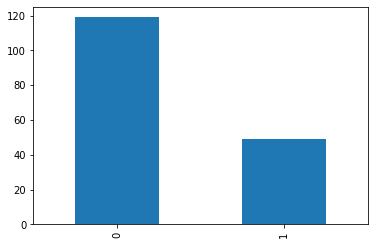

In [10]:
# Bar plot of y_train
y_train.value_counts().plot(kind='bar')

## Baseline Accuracy

In [11]:
# Establishing Baseline Accuracy
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:',baseline_acc)

Baseline accuracy: 0.7083333333333334


## Build Models

### Logistic Regression

In [12]:
# # Instantiating Logistic regression
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter = 100,random_state=42))

# Fit the model
model_lr.fit(X_train, y_train);

### Random Forest Classifier

In [13]:
# Instantiating Random forest classifier
model_rfc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42))

# Fit the model
model_rfc.fit(X_train, y_train);

### Decision Tree Classifier

In [14]:
# Instantiating Decision Tree Classifier
model_dt = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, max_depth=15)
)

# Fit the model
model_dt.fit(X_train, y_train);

### Gradient Boosting Classifier

In [15]:
# Import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Instantiating GradientBoostingClassifier
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(max_depth=20,n_estimators=200)
)

# Fit the model
model_boost.fit(X_train, y_train);

## Tuning Model

In [16]:
# Tuning the model using RandomSearchCV
clf = make_pipeline(OrdinalEncoder(),
                    SimpleImputer(),
                    RandomForestClassifier(random_state=42,n_jobs=-1)
                    )
param_grid = {
    'simpleimputer__strategy':['mean','median','mode'],
    'randomforestclassifier__max_depth':range(5,40,5),
    'randomforestclassifier__n_estimators':range(15,115,35)
}

# Instantiating RandomizedSearchCV
model = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs = -1,
    cv = 15,
    verbose = 2,
    n_iter = 25
)

# Fit the model
model.fit(X_train,y_train);

Fitting 15 folds for each of 25 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   37.1s finished


## Model Performance Classification Metrics

In [17]:
print('Logestic Regression')
print('model_lr accuracy score for training', accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val', accuracy_score(y_val, model_lr.predict(X_val)))

print()
print('Random Forest Classifier')
print("Classification Accuracy:", model_rfc.score(X_train, y_train))
print("Validation Accuracy:", model_rfc.score(X_val, y_val))

print()
print('Decision Tree Classifier')
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt.predict(X_val)))

print()
print('RandomizedSearchCV')
print('Best score for `model`:', model.best_score_)
print('Best params for `model`:', model.best_params_)
print('Training Accuracy Score:', accuracy_score(y_train, model.predict(X_train)))
print('Validation Accuracy Score:', accuracy_score(y_val, model.predict(X_val)))
print('Testing Accuracy Score:', accuracy_score(y_test, model.predict(X_test)))

print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Logestic Regression
model_lr accuracy score for training 0.7976190476190477
model_lr accuracy score for val 0.75

Random Forest Classifier
Classification Accuracy: 1.0
Validation Accuracy: 0.8214285714285714

Decision Tree Classifier
model_dt accuracy score for training 1.0
model_dt accuracy score for val 0.7321428571428571

RandomizedSearchCV
Best score for `model`: 0.7681818181818182
Best params for `model`: {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 30}
Training Accuracy Score: 1.0
Validation Accuracy Score: 0.8571428571428571
Testing Accuracy Score: 0.6933333333333334

Boosting Model
Training accuracy: 1.0
Validation accuracy: 0.7321428571428571


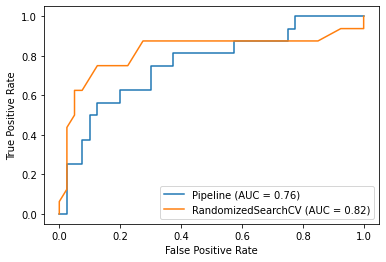

In [18]:
# Plotting ROC Curve for model_lr and model
from sklearn.metrics import recall_score, classification_report, roc_auc_score, plot_roc_curve
fig1 = plot_roc_curve(model_lr, X_val, y_val)
fig2 = plot_roc_curve(model, X_val, y_val, ax = fig1.ax_);

## Permutation Importance

In [19]:
column = 'platelets'
X_val_perm = X_val.copy()
X_val_perm[column] = np.random.permutation(X_val_perm[column])
perm_imp = permutation_importance(model, X_val, y_val, n_jobs=-1, random_state=42)

In [20]:
perm_imp['importances'][:,0:1].sum()

0.33928571428571375

In [21]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean', ascending=False)

importances['imp_mean']

serum_creatinine            1.178571e-01
ejection_fraction           6.428571e-02
age                         5.357143e-02
creatinine_phosphokinase    3.571429e-02
serum_sodium                3.214286e-02
platelets                   2.142857e-02
smoking                     1.785714e-02
diabetes                    1.071429e-02
high_blood_pressure         1.071429e-02
anaemia                    -2.220446e-17
Name: imp_mean, dtype: float64

In [22]:
importances['imp_mean'].index

Index(['serum_creatinine', 'ejection_fraction', 'age',
       'creatinine_phosphokinase', 'serum_sodium', 'platelets', 'smoking',
       'diabetes', 'high_blood_pressure', 'anaemia'],
      dtype='object')

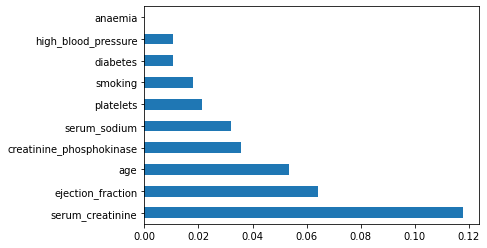

In [23]:
importances['imp_mean'].head(10).plot(kind='barh')

## Confusion Matrix

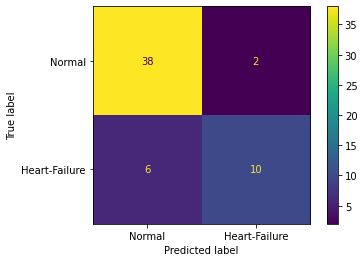

In [24]:
# Confusion matrix
plot_confusion_matrix(
    model,
    X_val, # BE SURE TO USE VALIDATION DATA
    y_val,
    values_format='.0f',
    display_labels=['Normal','Heart-Failure']
);



*   48 out of 56 predicted correctly
*   8 out of 56 is misclassified



### Classification Report

In [25]:
# metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score 
from sklearn.metrics import recall_score, classification_report, roc_auc_score, plot_roc_curve

print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        40
           1       0.83      0.62      0.71        16

    accuracy                           0.86        56
   macro avg       0.85      0.79      0.81        56
weighted avg       0.85      0.86      0.85        56



## Partial Dependence Plots(PDP)

1 Feature

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


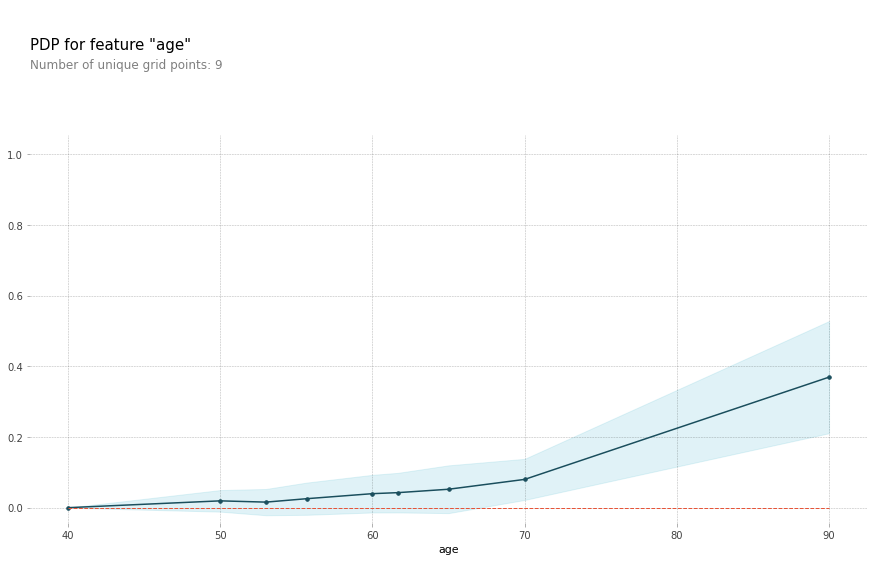

In [26]:
# Partial dependence plot for 'Age' feature.
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'age'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

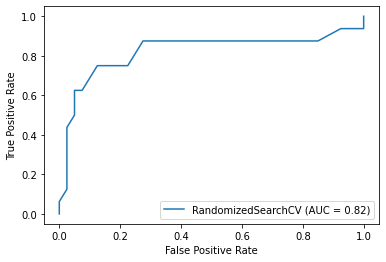

In [27]:
# points on the curve represent different classification thresholds
fig1 = plot_roc_curve(model, X_val, y_val)

2 Features

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


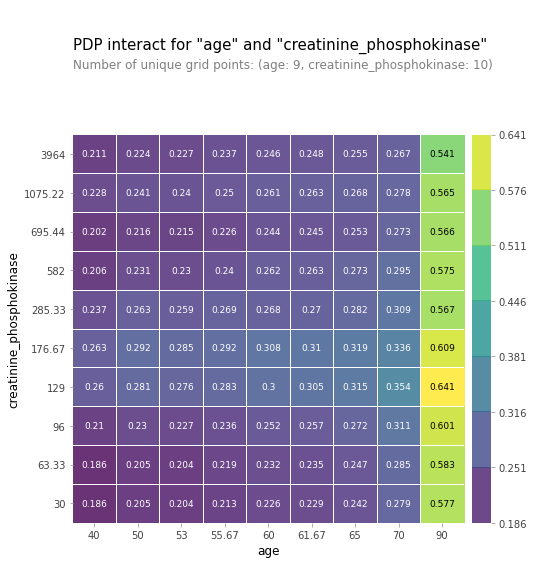

In [28]:
# Partial dependence plot for 'Age' and 'creatinine_phosphokinase' features.
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['age', 'creatinine_phosphokinase']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

## Conclusion

Metrics

*   Target variable(y) : 'Heart_failure' column
*   Leaky column : Removed 'time' feature with the help of feature importance.
*   Baseline Accuracy : 0.708
*   Logistic regression
      *   Training Accuracy : 0.79
      *   Validation Accuracy : 0.75
*   RandomSearchCV 
      *   Training Accuracy : 1.0
      *   Validation Accuracy : 0.83
      *   Test Accuracy : 0.69
      *   Best Score : 0.76
*   Precision : 0.83
*   Recall : 0.62

In-Depth Analysis

  I obtained the 'Heart Failure Prediction' dataset from Kaggle. This dataset has very little data cleaning to be performed. I split my dataset into featured matrix 'X' and the target vector 'y'.
  My target variable here is 'Heart_failure' column which is used to determine whether anybody is likely to get heart failure or not based on the input parameters.I am doing 'Binary classification' problem here. 
  I used sklearn.model_selection.train_test_split twice, first to split to train, test and then split train again into validation and train to report the test score of my selected model.
  I used models such as Logistic regression, Random Forest Classifier, Decision Tree Classifier, Random Search CV, and Gradiant Boosting Model to see how my score came out in building all these models. 
  Among all the models, the linear model with "Logistic regression" seems to generalize well with my dataset. I was able to tune the 'Hyperparameters' and got better scores with RandomSearchCV and considered it as my best model.
  Then I used permutation importance for model interpretation and feature selection and removed some of the 'Leaky columns' and some other features that are hardly correlated with my target variable.
  I plotted 'confusion matrix' and could easily see that my model predicted 47 of 56 predictions correctly and misclassified (confused) 9 of them.
  Finally plotted partial dependence plots for 1 feature and 2 features.
  To conclude, my model is 83% accurate in predictions.
  

























